# Deep Learning Tweets

### Importing Libraries

In [55]:
import _pickle as pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

### Loading the data

In [5]:
# Loading in the DF
with open("main_df.pkl",'rb') as fp:
    main_df = pickle.load(fp)

# Loading in the cleaned tweet data
with open("clean_tweets.pkl",'rb') as fp:
    data = pickle.load(fp)

### Train, test, split

In [7]:
X, y = data, main_df.City

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
# Categorizing the classes
y = pd.get_dummies(y).values

In [11]:
# Tokenizing the words and keeping the 1000 most common
tokenizer = text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X)
list_tokenized_tweets = tokenizer.texts_to_sequences(X)
X_t = sequence.pad_sequences(list_tokenized_tweets, maxlen=100)

### Creating the neural network

In [12]:
embedding_size = 500
input_ = Input(shape=(100,))
x = Embedding(1000, embedding_size)(input_)
x = LSTM(50, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are 2 different possible classes, so we use 2 neurons in our output layer
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

### Specifications for the model

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 500)          500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           110200    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

### Training the model

In [15]:
model.fit(X_t, y, epochs=3, batch_size=2000, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 16000 samples, validate on 4000 samples
Epoch 1/3
16000/16000 [==============================] - 32s 2ms/step - loss: 0.6780 - accuracy: 0.5892 - val_loss: 0.9527 - val_accuracy: 0.0000e+00
Epoch 2/3
16000/16000 [==============================] - 27s 2ms/step - loss: 0.6675 - accuracy: 0.6234 - val_loss: 0.8753 - val_accuracy: 0.0000e+00
Epoch 3/3
16000/16000 [==============================] - 27s 2ms/step - loss: 0.6637 - accuracy: 0.6244 - val_loss: 0.9232 - val_accuracy: 0.0000e+00


## Alternative Approach to the Neural Network

In [66]:
# Assigning the correct data
tweets = data

# Tokenizing the the data and keeping the 2000 most common words
tokenizer = text.Tokenizer(num_words=2000)

# Fitting the tweets on the tokenizer
tokenizer.fit_on_texts(tweets)

# Transforms each word in in the tweet into an integer
sequences = tokenizer.texts_to_sequences(tweets)

# Converts the list of texts into a matrix
one_hot_results = tokenizer.texts_to_matrix(tweets, mode='binary')

# Creating a dictionary of words
word_index = tokenizer.word_index

In [67]:
# Reversing the dictionary
reverse_index = dict([(value, key) for (key, value) in word_index.items()])

In [68]:
comment_idx_to_preview = 19
print('Original complaint text:')
print(tweets[comment_idx_to_preview])
print('\n\n')

#The reverse_index cell block above must be complete in order for this cell block to successively execute.
decoded_review = ' '.join([reverse_index.get(i) for i in sequences[comment_idx_to_preview]])
print('Decoded review from Tokenizer:')
print(decoded_review)

Original complaint text:
putin back trump 



Decoded review from Tokenizer:
putin back trump


In [69]:
city = main_df["City"]

le = preprocessing.LabelEncoder() #Initialize. le used as abbreviation fo label encoder
le.fit(city)
print("Original class labels:")
print(list(le.classes_))
print('\n')
city_cat = le.transform(city)  

print('New product labels:')
print(city_cat)
print('\n')


print('One hot labels; 2 binary columns, one for each of the categories.') #Each row will be all zeros except for the category for that observation.
city_onehot = to_categorical(city_cat)
print(city_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(city_onehot))

Original class labels:
['Jacksonville', 'Seattle']


New product labels:
[1 1 1 ... 0 0 0]


One hot labels; 2 binary columns, one for each of the categories.
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


One hot labels shape:
(20000, 2)


### Train, test, split

In [90]:
X, y = one_hot_results, city_onehot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Test label shape:", np.shape(y_test))
print("Train label shape:", np.shape(y_train))
print("Test shape:", np.shape(X_test))
print("Train shape:", np.shape(X_train))

Test label shape: (4000, 2)
Train label shape: (16000, 2)
Test shape: (4000, 2000)
Train shape: (16000, 2000)


## Creating the Neural Network

In [173]:
# Instatiating the model
model = Sequential()

# Regular Densely connected NN layer
model.add(Dense(50, activation='relu', input_shape=(2000,))) # Shape is equal to the number of most common words

# Dropping out to prevent overfitting
model.add(Dropout(.3))

# Another Dense layer with 25 outputs and dropping out half
model.add(Dense(25, activation='relu'))
model.add(Dropout(.5))

# Last layer with 2 outputs to represent the number of classes
model.add(Dense(2, activation='softmax'))

### Model Specifications

In [174]:
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [175]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 50)                100050    
_________________________________________________________________
dropout_41 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_42 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 2)                 52        
Total params: 101,377
Trainable params: 101,377
Non-trainable params: 0
_________________________________________________________________


### Fitting and Training the NN

In [192]:
history = model.fit(X_train, y_train, epochs=100, batch_size=256)

Epoch 1/100
16000/16000 [==============================] - 0s 27us/step - loss: 0.6570 - accuracy: 0.6064
Epoch 2/100
16000/16000 [==============================] - 0s 28us/step - loss: 0.6571 - accuracy: 0.6091
Epoch 3/100
16000/16000 [==============================] - 0s 26us/step - loss: 0.6582 - accuracy: 0.6066
Epoch 4/100
16000/16000 [==============================] - 0s 27us/step - loss: 0.6573 - accuracy: 0.6108
Epoch 5/100
16000/16000 [==============================] - 0s 26us/step - loss: 0.6552 - accuracy: 0.6089
Epoch 6/100
16000/16000 [==============================] - 0s 28us/step - loss: 0.6565 - accuracy: 0.6102
Epoch 7/100
16000/16000 [==============================] - 0s 28us/step - loss: 0.6565 - accuracy: 0.6106
Epoch 8/100
16000/16000 [==============================] - 1s 31us/step - loss: 0.6547 - accuracy: 0.6090
Epoch 9/100
16000/16000 [==============================] - 0s 28us/step - loss: 0.6517 - accuracy: 0.6161
Epoch 10/100
16000/16000 [====================

16000/16000 [==============================] - 1s 37us/step - loss: 0.6187 - accuracy: 0.6562
Epoch 78/100
16000/16000 [==============================] - 1s 37us/step - loss: 0.6182 - accuracy: 0.6534
Epoch 79/100
16000/16000 [==============================] - 1s 41us/step - loss: 0.6212 - accuracy: 0.6475
Epoch 80/100
16000/16000 [==============================] - 1s 34us/step - loss: 0.6166 - accuracy: 0.6597
Epoch 81/100
16000/16000 [==============================] - 0s 29us/step - loss: 0.6183 - accuracy: 0.6538
Epoch 82/100
16000/16000 [==============================] - 0s 28us/step - loss: 0.6170 - accuracy: 0.6597
Epoch 83/100
16000/16000 [==============================] - 0s 26us/step - loss: 0.6153 - accuracy: 0.6625
Epoch 84/100
16000/16000 [==============================] - 0s 31us/step - loss: 0.6192 - accuracy: 0.6521
Epoch 85/100
16000/16000 [==============================] - 1s 32us/step - loss: 0.6163 - accuracy: 0.6599
Epoch 86/100
16000/16000 [========================

In [193]:
# Assigning the dictionary of the results from the training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

## Visualizing the Loss and Accuracy over time

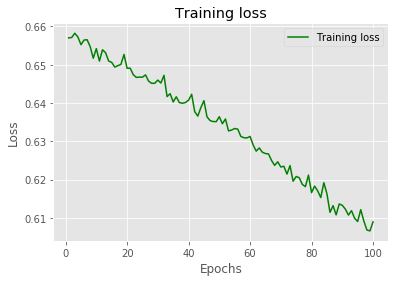

In [194]:
# Training Loss
history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

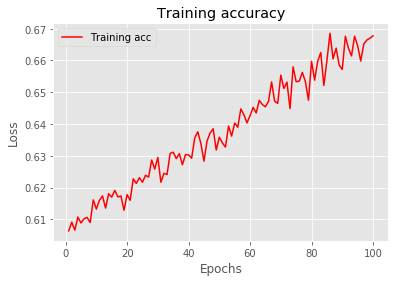

In [195]:
# Training Accuracy
acc_values = history_dict['accuracy'] 

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluating the trained model

In [197]:
results_train = model.evaluate(X_train, y_train)
results_train

16000/16000 [==============================] - 1s 45us/step


[0.572358312368393, 0.7196249961853027]

In [198]:
results_test = model.evaluate(X_test, y_test)
results_test

4000/4000 [==============================] - 0s 53us/step


[0.6555700607299805, 0.6012499928474426]

In [199]:
mod_train_preds = model.predict(X_train)
mod_test_preds = model.predict(X_test)

mod_train_score = accuracy_score(y_train.argmax(axis=1), mod_train_preds.argmax(axis=1))
mod_test_score = accuracy_score(y_test.argmax(axis=1), mod_test_preds.argmax(axis=1))

print("Deep Learning")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(mod_train_score, mod_test_score))

Deep Learning
Training Accuracy: 0.7196 		 Testing Accuracy: 0.6012
